In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
import os
%matplotlib inline


In [57]:
df = pd.read_csv('../data/all.csv')
df = df.dropna(subset=['lyrics'])
df = df.reset_index(drop=True)

import re

def remove_disclaimer(string):
    s = re.sub(r'(\*)+ This Lyrics is NOT for Commercial use .*\r\n\([0-9]*\)',"", string)
    return s

df['lyrics'] = df['lyrics'].apply(remove_disclaimer)

In [9]:
df.shape

(14270, 34)

In [84]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor


X = df[['lyrics']]
y = df['Age']

#X_train, y_train = shuffle(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

bag_of_words_model = Pipeline([
    ('vectorizer', ColumnTransformer([('counter', CountVectorizer(),'lyrics')])),
    ('regressor', Ridge())     
])


param_grid = {'regressor__alpha':[0, 5, 10, 15, 20], 'vectorizer__counter__min_df': [2], 
              'vectorizer__counter__max_df': [0.9, 0.95]}


gs_est = GridSearchCV(bag_of_words_model, param_grid, cv=3, n_jobs=2, verbose=1, return_train_score = True)
model = gs_est.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [83]:
gs_est.best_estimator_

Pipeline(steps=[('vectorizer',
                 ColumnTransformer(transformers=[('counter',
                                                  CountVectorizer(min_df=0.01),
                                                  'lyrics')])),
                ('regressor', Ridge(alpha=20))])

In [81]:
gs_est.cv_results_['mean_test_score']

array([0.2454161 , 0.23061965, 0.21190575, 0.24904288, 0.23072692,
       0.21193356, 0.25232989, 0.23083198, 0.21196124, 0.2552335 ,
       0.23093487, 0.21198859, 0.25784045, 0.23103565, 0.21200502])

ValueError: x and y must have same first dimension, but have shapes (5,) and (15,)

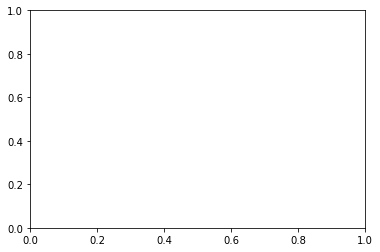

In [80]:
alpha = gs_est.param_grid['regressor__alpha']

plt.plot(alpha, gs_est.cv_results_['mean_test_score'], c='r', label = 'validation score')
plt.plot(alpha, gs_est.cv_results_['mean_train_score'], c='b', label = 'train score')
plt.xlabel('regressor_alpha')
plt.ylabel('score')
plt.legend(loc='upper right');

In [72]:
gs_est.best_score_

0.25784044677877066

In [74]:
y_pred = gs_est.predict(X_test)

In [79]:
from sklearn.metrics import mean_squared_error, r2_score

print ("Error (RMSE): ", mean_squared_error(y_test, y_pred, squared=False))
print ("R^2 Score: " , r2_score(y_test, y_pred))

Error (RMSE):  3.4908759119257327
R^2 Score:  0.25255771780268643
